In [233]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
import sklearn.linear_model
from keras.utils import to_categorical
import gast as gast

In [234]:
class NeuralNet:
    
    """
    NN for binary classification
    Attributes:
    ...
    """
 
    def __init__(self, normalize = True, learning_rate = 0.01, ammount_iter = 30000, hidden_layer_sizes=(100,), e=1e-6):
        self.learning_rate = learning_rate
        self.ammount_iter = ammount_iter
        self.normalize = normalize
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_layers = 1 + len(hidden_layer_sizes)
        self.e = e
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s**2
        return X_new, m, s

    def __sigmoid(self, Z):
        return 1 / (1 + np.exp(-Z))
    
    def softmax(self, Z):
        expZ = np.exp(Z - np.max(Z))
        return expZ / expZ.sum(axis=0, keepdims=True)
    
    def __initialize_parameters(self, n_x, hidden_layers, n_y):
        np.random.seed(1)
        W = list()
        b = list()
        
        h = list(hidden_layers)
        h.insert(0, n_x)
        h.append(n_y)
        hidden_layers = tuple(h)
        
        for l in range(1, self.n_layers+1):
            W.append(np.random.randn(hidden_layers[l], hidden_layers[l-1]) / np.sqrt(
                hidden_layers[l - 1]))
            b.append(np.zeros((hidden_layers[l], 1)))

        self.parameters = {"W" : W, "b" : b}
    
    def __forward_process(self, X):
        W = self.parameters["W"]
        b = self.parameters["b"]

        A = list()
        Z = list()
               
        for l in range(0, self.n_layers-1):
            if l == 0:
                Z.append(np.dot(W[l], X) + b[l])
            else:
                Z.append(np.dot(W[l], A[l-1]) + b[l])
            A.append(self.__sigmoid(Z[l]))
        
        Z.append(np.dot(W[-1], A[-1]) + b[-1])
        A.append(self.softmax(Z[-1]))
        
        cache = (W, b, Z, A)

        return A[-1], cache
    
    def __backward_process(self, X, Y, cache):
        m = X.shape[1]
        n = X.shape[0]
        (W, b, Z, A) = cache
        
        dW = [None] * (self.n_layers)
        dA = [None] * (self.n_layers)
        dZ = [None] * (self.n_layers)
        db = [None] * (self.n_layers)
              
        dZ[-1] = (A[-1] - Y)
        dW[-1] = (1. / m * np.dot(dZ[-1], A[-2].T))
        db[-1] = (1. / m * np.sum(dZ[-1], axis = 1, keepdims = True))
        dA[-1] = np.dot(W[-1].T, dZ[-1])
        
        for l in range(self.n_layers-1, 0, -1):
            dZ[l-1] = np.multiply(dA[l], self.__sigmoid_derivative(Z[l-1]))
            if l-1 == 0:
                dW[l-1] = 1. / m * np.dot(dZ[l-1], X.T)
            else:
                dW[l-1] = 1. / m * np.dot(dZ[l-1], A[l-2].T)
            db[l-1] = 1. / m * np.sum(dZ[l-1], axis = 1, keepdims = True) 
            dA[l-1] = np.dot(W[l-1].T, dZ[l-1])
        
        grads = {"dZ" : dZ, "dW" : dW, "db" : db}
        return grads
    
    def compute_cost(self, A, Y):
        return -np.mean(Y.T * np.log(A.T+ 1e-8))
    
    def cross_entropy(self, A, Y):
        return - np.sum(np.log(A) * (Y), axis=1)
    
    def __sigmoid_derivative(self, Z):
        s = 1 / (1 + np.exp(-Z))
        return np.multiply(s, (1 - s))
    
    
    def __update_parameters(self, grads):
        W = self.parameters["W"]
        b = self.parameters["b"]

        dW = grads["dW"]
        db = grads["db"]
        
        for i in range(self.n_layers):
            W[i] = W[i] - self.learning_rate * dW[i]
            b[i] = b[i] - self.learning_rate * db[i]

    def fit(self, X_vert, Y_vert, print_cost = True):
        self.n_iter = 0
        X, Y = X_vert.T, Y_vert.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        cost_history = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        n_y = Y.shape[0]
        
        self.__initialize_parameters(n_x, self.hidden_layer_sizes, n_y)

        for i in range(self.ammount_iter):
            self.n_iter = i
            A, cache = self.__forward_process(X)

            cost = self.compute_cost(A, Y)

            grads = self.__backward_process(X, Y, cache)

            self.__update_parameters(grads)
            
            cost_history.append(cost)
            
            if print_cost and i % 100 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 100 == 0:
                costs.append(cost)
  
            if i > 1 and abs(cost-cost_history[-2]) < self.e:
                print('Stopping gradient descent ...')
                break

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
        
        probs = self.__forward_process(X)[0]
        
        return probs.T
    
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        y_pred = self.to_classlabel(positive_probs)
        return y_pred  

    def to_classlabel(self, z):
        return z.argmax(axis=1)

In [235]:
df = pd.read_csv("C:/Users/User/Desktop/ml/neural_ml/tests.csv")
df.head()

,test1,test2,passed
0,0.46601,-0.53582,1
1,0.32200,0.58260,1
2,-0.75518,0.29020,0
3,-0.10426,0.99196,0
4,-0.40956,-0.41155,0


In [236]:
data_columns = ["test1", "test2"]
target_column = "passed"
X, Y = df[data_columns].values, df[target_column]



In [237]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y.values.reshape((Y.shape[0], 1)), test_size = 0.2, random_state=10)
print('Training set: X={}, y={}'.format(X_train.shape, Y_train.shape))
print('Test set: X={}, y={}'.format(X_test.shape, Y_test.shape))

Training set: X=(94, 2), y=(94, 1)
Test set: X=(24, 2), y=(24, 1)


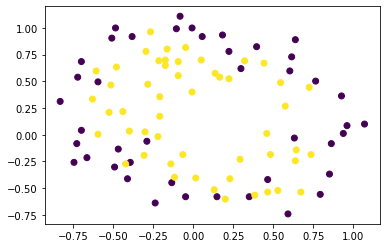

In [238]:
def plot_data(X, y):
    ax = plt.gca()
    ax.scatter(X[:,0], X[:,1], c=(y == 1))
plot_data(X_train, Y_train)

In [239]:
Y_train = to_categorical(Y_train) # One hot encoder
Y_train.shape

(94, 2)

In [232]:
cls = NeuralNet(normalize = True, learning_rate = 0.1, ammount_iter = 1000, hidden_layer_sizes=(50, ), e=1e-6)

In [225]:
cls.n_layers


2

0-th iteration: 0.35280963053951014
100-th iteration: 0.5408762750697846
200-th iteration: 0.26032488215373806
300-th iteration: 0.20661571462259648
400-th iteration: 0.19029223484234145
500-th iteration: 0.1817146728560283
600-th iteration: 0.1761785102136467
700-th iteration: 0.17167403453474123
800-th iteration: 0.16750092433848895
900-th iteration: 0.16385232347537693


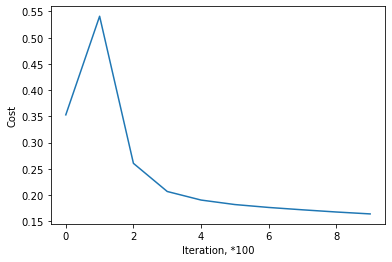

In [226]:
cls.fit(X_train, Y_train)

In [227]:
cls.n_iter

999

In [228]:
Y_prob = cls.predict_proba(X_test)
print(Y_prob.shape)
Y_prob

(24, 2)


array([[0.0169405 , 0.9830595 ],
       [0.93423865, 0.06576135],
       [0.97402296, 0.02597704],
       [0.40293456, 0.59706544],
       [0.82998022, 0.17001978],
       [0.39647472, 0.60352528],
       [0.90455555, 0.09544445],
       [0.39333529, 0.60666471],
       [0.82068218, 0.17931782],
       [0.67291068, 0.32708932],
       [0.99665756, 0.00334244],
       [0.00607656, 0.99392344],
       [0.72239147, 0.27760853],
       [0.60799246, 0.39200754],
       [0.25990007, 0.74009993],
       [0.11131085, 0.88868915],
       [0.00934027, 0.99065973],
       [0.15063132, 0.84936868],
       [0.93118401, 0.06881599],
       [0.83242524, 0.16757476],
       [0.44964367, 0.55035633],
       [0.00123198, 0.99876802],
       [0.95988068, 0.04011932],
       [0.8585328 , 0.1414672 ]])

In [229]:
Y_prob[0][0:10].sum()

1.0

In [230]:
Y_hat = cls.predict(X_test)
Y_hat

array([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0], dtype=int64)

In [231]:
accuracy_score(Y_test, Y_hat)

0.8333333333333334